In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import emoji
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove user @ references and '#'
    tweet = re.sub(r'\@\w+|\#', '', tweet)

    # Convert emojis to text
    tweet = emoji.demojize(tweet)

    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    word_tokens = word_tokenize(tweet)

    return " ".join(word_tokens)


In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Text Mining/Constraint_Train.csv")

data['processed_tweet'] = data['tweet'].apply(preprocess_tweet)

In [ ]:
data["label"] = data["label"].map({"real": 1, "fake": 0})

In [ ]:
val = pd.read_csv('/content/drive/MyDrive/Text Mining/Constraint_Val.csv')
val["label"] = val["label"].map({"real": 1, "fake": 0})

preprocessed texts and adds in dataframe

In [ ]:
data.head()

,id,tweet,label,processed_tweet
0,1,The CDC currently reports 99031 deaths. In gen...,1,the cdc currently reports 99031 deaths in gene...
1,2,States reported 1121 deaths a small rise from ...,1,states reported 1121 deaths a small rise from ...
2,3,Politically Correct Woman (Almost) Uses Pandem...,0,politically correct woman almost uses pandemic...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1,indiafightscorona we have 1524 covid testing l...
4,5,Populous states can generate large case counts...,1,populous states can generate large case counts...


tokenizing the data

In [ ]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tweets = data.processed_tweet.values
labels = data.label.values

In [ ]:
print(tweets)

['the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today'
 'states reported 1121 deaths a small rise from last tuesday southern states reported 640 of those deaths'
 'politically correct woman almost uses pandemic as excuse not to reuse plastic bag coronavirus nashville'
 ...
 'a post claims a covid19 vaccine has already been developed and will cause widespread infertility'
 'aamir khan donate 250 cr in pm relief cares fund'
 'it has been 93 days since the last case of covid19 was acquired locally from an unknown source the total number of active cases of covid19 in new zealand ’ s managed isolation and quarantine facilities is now 25']


In [ ]:
# Print the original sentence.
print(' Original: ', tweets[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today
Tokenized:  ['the', 'cdc', 'currently', 'reports', '99', '##0', '##31', 'deaths', 'in', 'general', 'the', 'disc', '##re', '##pan', '##cies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'ex', '##pl', '##ica', '##ble', 'the', 'death', 'toll', 'stands', 'at', 'roughly', '1000', '##00', 'people', 'today']
Token IDs:  [1996, 26629, 2747, 4311, 5585, 2692, 21486, 6677, 1999, 2236, 1996, 5860, 2890, 9739, 9243, 1999, 2331, 9294, 2090, 2367, 4216, 2024, 2235, 1998, 4654, 24759, 5555, 3468, 1996, 2331, 9565, 4832, 2012, 5560, 6694, 8889, 2111, 2651]


In [ ]:
max_len = 0
ind = [100,200,300,400,500,512]
for i in ind:
  count = 0
  for tweet in tweets:
      max_len = max(max_len, len(tweet))
      if len(tweet)>i:
        count+=1
  print("Count of sentence length over {} is: ".format(i), count)
print('Max sentence length: ', max_len)

Count of sentence length over 100 is:  4541
Count of sentence length over 200 is:  2072
Count of sentence length over 300 is:  69
Count of sentence length over 400 is:  15
Count of sentence length over 500 is:  8
Count of sentence length over 512 is:  7
Max sentence length:  8692


ML

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'data' is your DataFrame and 'processed_tweet' is the preprocessed text column
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['processed_tweet']).toarray()
y = data['label'].values

# Splitting the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Initialize and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Validate the model
svm_predictions = svm_model.predict(X_val)

# Calculate accuracy, F1 score, etc.
from sklearn.metrics import accuracy_score, f1_score
print("SVM Accuracy:", accuracy_score(y_val, svm_predictions))
print("SVM F1 Score:", f1_score(y_val, svm_predictions))
print("XGBoost Precision:", precision_score(y_val, svm_predictions))
print("XGBoost Recall:", recall_score(y_val, svm_predictions))

SVM Accuracy: 0.926791277258567
SVM F1 Score: 0.930576070901034
XGBoost Precision: 0.9347181008902077
XGBoost Recall: 0.9264705882352942


Testing SVM

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Text Mining/Constraint_Val.csv')
test_data["label"] = test_data["label"].map({"real": 1, "fake": 0})

In [ ]:
test_data.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,0
1,2,11 out of 13 people (from the Diamond Princess...,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0
3,4,Mike Pence in RNC speech praises Donald Trump’...,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,1


In [ ]:
test_data['processed_tweet'] = test_data['tweet'].apply(preprocess_tweet)

# Vectorize the processed tweets (use the same vectorizer as you used for training)
X_test = vectorizer.transform(test_data['processed_tweet']).toarray()
y_test = test_data['label'].values

In [ ]:
# Predict on test set
svm_test_predictions = svm_model.predict(X_test)

# Calculate performance metrics
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
svm_test_f1 = f1_score(y_test, svm_test_predictions)

print("SVM Test Accuracy:", svm_test_accuracy)
print("SVM Test F1 Score:", svm_test_f1)


SVM Test Accuracy: 0.914018691588785
SVM Test F1 Score: 0.9179304192685102


error analysis

In [ ]:
svm_errors = np.where(svm_test_predictions != y_test)[0]

# Print the misclassified tweets
print("Misclassified Tweets by SVM:")
for index in svm_errors:
    print(f"Tweet: {test_data['tweet'].iloc[index]}")
    print(f"Predicted: {svm_test_predictions[index]}, Actual: {y_test[index]}\n")

Misclassified Tweets by SVM:
Tweet: 11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.
Predicted: 1, Actual: 0

Tweet: You can still fly the friendly skies without fear of COVID if airlines stay serious about safety. https://t.co/H8mGjwDl7G #coronavirus
Predicted: 0, Actual: 1

Tweet: Tomorrow April 6 we will pass 10000 coronavirus deaths. We passed 5000 on April 2. We passed 1000 on March 26. We passed 100 on March 18.
Predicted: 0, Actual: 1

Tweet: Gov. Andrew Cuomo “was simply saying if we can share 20 percent of your excess your non-used ventilators to help people in other parts of the state on a voluntary basis that would be great. Of course there was a reaction to that which was not positive."
Predicted: 1, Actual: 0

Tweet: Everyone can help prevent spread of #COVID19. Clara the #Coronavirus Self-Checker can help you decide when to call your doctor if you are fe

XGBOOST

In [ ]:
import xgboost as xgb

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Validate the model
xgb_predictions = xgb_model.predict(X_val)

# Calculate accuracy, F1 score, etc.
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_predictions))
print("XGBoost F1 Score:", f1_score(y_val, xgb_predictions))


XGBoost Accuracy: 0.9112149532710281
XGBoost F1 Score: 0.9140271493212669


Testing with XGBoost

In [ ]:
# Predict on test set
xgb_test_predictions = xgb_model.predict(X_test)

# Calculate performance metrics
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)
xgb_test_f1 = f1_score(y_test, xgb_test_predictions)

print("XGBoost Test Accuracy:", xgb_test_accuracy)
print("XGBoost Test F1 Score:", xgb_test_f1)


XGBoost Test Accuracy: 0.8859813084112149
XGBoost Test F1 Score: 0.8897922312556459


Error Analysis

In [ ]:
xgb_errors = np.where(xgb_test_predictions != y_test)[0]
print("Misclassified Tweets by XGBoost:")
for index in xgb_errors:
    print(f"Tweet: {test_data['tweet'].iloc[index]}")
    print(f"Predicted: {xgb_test_predictions[index]}, Actual: {y_test[index]}\n")

Misclassified Tweets by XGBoost:
Tweet: 11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.
Predicted: 1, Actual: 0

Tweet: News and media outlet ABP Majha on the basis of an internal memo of South Central Railway reported that a special train has been announced to take the stranded migrant workers home.
Predicted: 1, Actual: 0

Tweet: You can still fly the friendly skies without fear of COVID if airlines stay serious about safety. https://t.co/H8mGjwDl7G #coronavirus
Predicted: 0, Actual: 1

Tweet: Tomorrow April 6 we will pass 10000 coronavirus deaths. We passed 5000 on April 2. We passed 1000 on March 26. We passed 100 on March 18.
Predicted: 0, Actual: 1

Tweet: Breathlessness excessive fatigue and muscle aches from COVID can last for months. https://t.co/OUhBRirKpE
Predicted: 0, Actual: 1

Tweet: Everyone can help prevent spread of #COVID19. Clara the #Coronavirus S

ADA Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize and train the AdaBoost model
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

# Validate the model
ada_predictions = ada_model.predict(X_val)

# Calculate accuracy, F1 score, etc.
print("AdaBoost Accuracy:", accuracy_score(y_val, ada_predictions))
print("AdaBoost F1 Score:", f1_score(y_val, ada_predictions))


AdaBoost Accuracy: 0.8426791277258567
AdaBoost F1 Score: 0.8476621417797888


Testing with ADABoost

In [ ]:
# Predict on test set
ada_test_predictions = ada_model.predict(X_test)

# Calculate performance metrics
ada_test_accuracy = accuracy_score(y_test, ada_test_predictions)
ada_test_f1 = f1_score(y_test, ada_test_predictions)

print("AdaBoost Test Accuracy:", ada_test_accuracy)
print("AdaBoost Test F1 Score:", ada_test_f1)


AdaBoost Test Accuracy: 0.8373831775700935
AdaBoost Test F1 Score: 0.8412408759124087


errors with ADA

In [ ]:
ada_errors = np.where(ada_test_predictions != y_test)[0]

# Print the misclassified tweets
print("Misclassified Tweets by AdaBoost:")
for index in ada_errors:
    print(f"Tweet: {test_data['tweet'].iloc[index]}")
    print(f"Predicted: {ada_test_predictions[index]}, Actual: {y_test[index]}\n")

Misclassified Tweets by AdaBoost:
Tweet: 11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.
Predicted: 1, Actual: 0

Tweet: News and media outlet ABP Majha on the basis of an internal memo of South Central Railway reported that a special train has been announced to take the stranded migrant workers home.
Predicted: 1, Actual: 0

Tweet: You can still fly the friendly skies without fear of COVID if airlines stay serious about safety. https://t.co/H8mGjwDl7G #coronavirus
Predicted: 0, Actual: 1

Tweet: Tomorrow April 6 we will pass 10000 coronavirus deaths. We passed 5000 on April 2. We passed 1000 on March 26. We passed 100 on March 18.
Predicted: 0, Actual: 1

Tweet: Breathlessness excessive fatigue and muscle aches from COVID can last for months. https://t.co/OUhBRirKpE
Predicted: 0, Actual: 1

Tweet: EMA endorses the use of dexamethasone for COVID-19. https://t.co/RKPH

BERT

In [ ]:
import torch
input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today
Token IDs: tensor([  101,  1996, 26629,  2747,  4311,  5585,  2692, 21486,  6677,  1999,
         2236,  1996,  5860,  2890,  9739,  9243,  1999,  2331,  9294,  2090,
         2367,  4216,  2024,  2235,  1998,  4654, 24759,  5555,  3468,  1996,
         2331,  9565,  4832,  2012,  5560,  6694,  8889,  2111,  2651,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

approach 1

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,778 training samples
  642 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            shuffle = True,
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            shuffle = False,
            batch_size = batch_size
        )

bert tuning

In [ ]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Check if GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Move the model to the chosen device
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from torch.optim import AdamW
import torch.nn as nn
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )
epochs = 4
criterion = nn.CrossEntropyLoss()

training

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))


Epoch 1 / 4
Training...
  Accuracy: 0.894773277950848
  Training loss: 0.016914128029381154

Epoch 2 / 4
Training...
  Accuracy: 0.9672897196261683
  Training loss: 0.008012700649896298

Epoch 3 / 4
Training...
  Accuracy: 0.9837313949463482
  Training loss: 0.004295884765488041

Epoch 4 / 4
Training...
  Accuracy: 0.9956732433367947
  Training loss: 0.0014028802209270527


In [ ]:
from sklearn.metrics import roc_auc_score,f1_score

for epoch_i in range(0, epochs):
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print("Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model(input_ids, token_type_ids=None, attention_mask=input_mask,labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    print()

    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print('roc_auc score: ', roc_auc_score(y_true,y_pred))
print('F1 score:',f1_score(y_true, y_pred))

Epoch 1 / 4
Validation...
  Accuracy: 0.9548286604361371
  Validation loss: 0.023867352310124917



Epoch 2 / 4
Validation...
  Accuracy: 0.9548286604361371
  Validation loss: 0.023867352310124917



Epoch 3 / 4
Validation...
  Accuracy: 0.9548286604361371
  Validation loss: 0.023867352310124917



Epoch 4 / 4
Validation...
  Accuracy: 0.9548286604361371
  Validation loss: 0.023867352310124917



roc_auc score:  0.9539427433213561
F1 score: 0.9583931133428981


In [ ]:
PATH1 = "/content/drive/MyDrive/'bert_finetune.pt'"
torch.save(model, PATH1)

Error analysis for BERT

In [ ]:
# List to store misclassified tweets
misclassified_tweets = []

# Put the model in evaluation mode
model.eval()

# No need to track gradients for this
with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass, calculate logit predictions
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask)
        logits = out[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions = np.argmax(logits, axis=1)

        # Compare predictions with true labels
        for input_id, prediction, true_label in zip(input_ids, predictions, label_ids):
            if prediction != true_label:
                decoded_tweet = tokenizer.decode(input_id, skip_special_tokens=True)
                misclassified_tweets.append((decoded_tweet, true_label, prediction))

# Print misclassified tweets
for tweet, true_label, pred_label in misclassified_tweets:
    print(f"Tweet: {tweet}\nTrue Label: {true_label}, Predicted Label: {pred_label}\n")


Tweet: dr anthony fauci said a covid19 vaccine must be delivered to people without proper studies being carried out
True Label: 0, Predicted Label: 1

Tweet: trump says 200000 us coronavirus deaths is a shame
True Label: 1, Predicted Label: 0

Tweet: from a progress report on covid19 in the journal nature researchers used vero cells — which do not express tmprss2 — in an early study that suggested that the drug chloroquine might work as a treatment for covid19 13
True Label: 0, Predicted Label: 1

Tweet: we think of it as setting up a roadblock if youre someone who can make this chart and knows how to think about this data then fine if youre someone who will tweet a high number without putting those error bars in your mind thats bad we dont need any more virality
True Label: 1, Predicted Label: 0

Tweet: people like dr eric coe are jumping at the chance to help test a coronavirus vaccine
True Label: 1, Predicted Label: 0

Tweet: this uk study randomly assigned over 4600 patients with c

**Trying Ensembled methods**

LDA and K means

In [ ]:
docs = data['processed_tweet'].tolist()
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction import text

from sklearn.feature_extraction import text
my_stopwords = text.ENGLISH_STOP_WORDS
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=list(my_stopwords))
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(len(tfidf_vectorizer.vocabulary_))


6931


In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 10
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0)
lda_z = lda.fit_transform(tfidf)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

In [ ]:
display_topics(lda, tfidf_feature_names, no_top_words)

Topic 0:
completed tests yesterday laboratories date tested number processed bringing people
Topic 1:
amitabh quarantined bachchan roche space company coffee patrick launch announced
Topic 2:
cases covid19 new confirmed total indiafightscorona number india deaths active
Topic 3:
bleach miracle dies caused fans sold industrial herman property cars
Topic 4:
coronavirus covid19 people new vaccine pandemic virus covid says trump
Topic 5:
spread covid19 tests face published help daily update wear protect
Topic 6:
holding juice nobel honjo percent tasuku laureate manufactured mail lewis
Topic 7:
died ali herd haji foundation sex gates immunity italians pradhan
Topic 8:
2020 tunisian skin 0800 rightarrowdeaths september rightarrowactive rightarrowconfirmed rightarrowrecovered cureddischargedmigrated
Topic 9:
coca procedures hcps et topic 2pm considerations event zoom profile


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Assuming 'data' is your DataFrame with 'processed_tweet' and 'label' columns
fake_tweets = data[data['label'] == 0]['processed_tweet']
real_tweets = data[data['label'] == 1]['processed_tweet']

# Vectorize the tweets
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_fake = tfidf_vectorizer.fit_transform(fake_tweets)
tfidf_real = tfidf_vectorizer.fit_transform(real_tweets)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Define LDA model
no_topics = 10
lda_fake = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50., random_state=0)
lda_fake_model = lda_fake.fit(tfidf_fake)

# Applying LDA to real tweets
lda_real = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50., random_state=0)
lda_real_model = lda_real.fit(tfidf_real)

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics for fake tweets
print("Fake Tweets Topics:")
display_topics(lda_fake, tfidf_feature_names, no_top_words)

# Display topics for real tweets
print("\nReal Tweets Topics:")
display_topics(lda_real, tfidf_feature_names, no_top_words)


Fake Tweets Topics:
Topic 0:
masksfacewithmedicalmask tuesday entire 846395 surprising nor been standing emerging redcircletrump
Topic 1:
midwest asymptomatic 1206 1150 absence katsina14 however aged newsletter november
Topic 2:
spared 619 kwara4 dirty open publish 1172 advised mississippi admitted
Topic 3:
kowheori19 necessary indicates 86752 indiafightscorona treatments harding practice prompt conduct
Topic 4:
set bihar situation line finds breakdown 299 ginsburg distance service
Topic 5:
staysafe caused damage distribution publication opening sky kaduna32 employed presenting
Topic 6:
6pm acting peoples 34 66k freeview diseasedetective gombe4 percapita actnow
Topic 7:
183 breastfeeding sliding error cruise strict 2970492 instructions johnson host
Topic 8:
apart success specialist 52k samples antigens london investigation long creating
Topic 9:
diagnostics saved sample playbutton160 park fct50 transparent blacksmallsquare 4497867 rivers1

Real Tweets Topics:
Topic 0:
we in that ll how

Fake Tweets Topics:

Topic 0 - Mask and Political References: Discussions possibly involving masks and political figures.

Topic 1 - Midwest Asymptomatic Cases: Conversations about asymptomatic COVID-19 cases in the Midwest region.

Topic 2 - Regional Health Concerns: Focus on health issues in specific areas like Kwara and Mississippi.

Topic 3 - International COVID-19 Response: References to international responses and treatments for COVID-19.

Topic 4 - Health Situation in Bihar: Coverage of the COVID-19 situation specifically in Bihar.

Topic 5 - Safety and Damage Reports: Talks about safety measures and the damage caused by COVID-19.

Topic 6 - Public Health Announcements: Discussions on public health updates and announcements.

Topic 7 - Health Guidelines and Errors: Mention of health guidelines and reporting errors or miscommunications.

Topic 8 - Medical Investigations: References to medical investigations, sample testing, and antigen studies.

Topic 9 - Diagnostics and Transparency: Focus on diagnostics, transparency in reporting, and specific regional updates.

Real Tweets Topics:

Topic 0 - Pediatric Healthcare Discussions: Conversations about pediatric healthcare and patient care increase.

Topic 1 - App Feedback and Technical Queries: Issues related to a tracing app and technical support.

Topic 2 - Corporate and Organizational Response: Discussion on responses by organizations like John Lewis Partnership.

Topic 3 - Testing and Restrictions: Updates on COVID-19 testing, backlogs, and related restrictions.

Topic 4 - Nigeria COVID-19 Reports: Information about COVID-19 in Nigeria, including cases and recoveries.

Topic 5 - Government Measures and Shortages: Talks about government actions, possible shortages, and public notices.

Topic 6 - Regional COVID-19 Effects: Focus on the impact of COVID-19 in specific regions like Yorkshire and Midlands.

Topic 7 - Recent COVID-19 Updates: Current updates and reports on COVID-19 cases and trends.

Topic 8 - India COVID-19 Awareness and Safety: Discussions on COVID-19 in India, emphasizing safety and awareness.

Topic 9 - General COVID-19 Information: General information and discussions about COVID-19, including cases and health advice.

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def display_word_clouds(lda_model, feature_names, num_topics, num_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        # Pull out the most relevant words for this topic
        top_features_ind = topic.argsort()[:-num_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_words = ' '.join(top_features)

        # Generate a word cloud for these words
        wordcloud = WordCloud(width=800, height=600, background_color='white').generate(top_words)

        # Display the word cloud
        plt.figure(figsize=(3,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_idx+1}', fontsize=18)
        plt.axis("off")

    plt.show()

# Number of words to include in each word cloud
num_words = 20

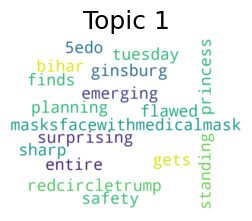

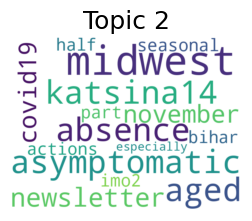

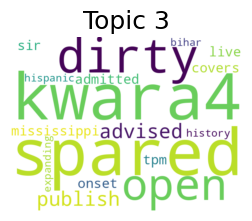

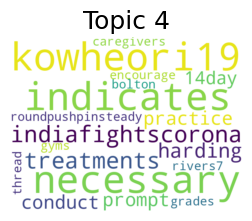

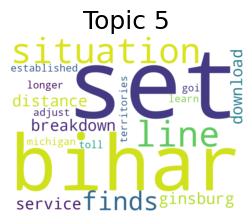

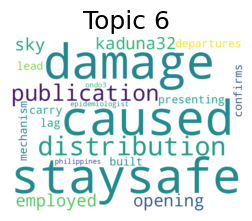

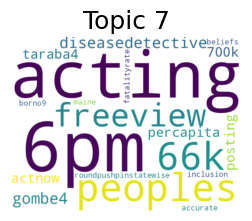

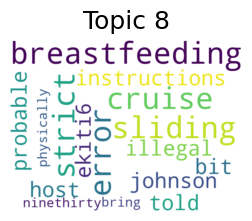

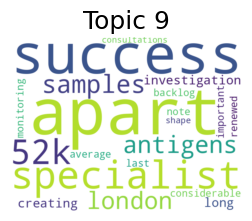

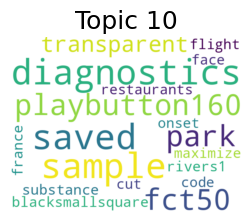

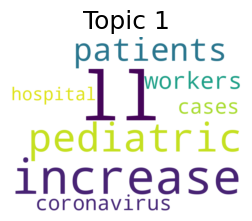

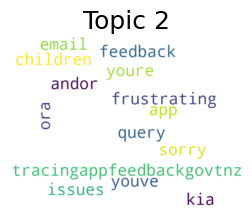

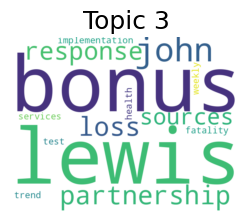

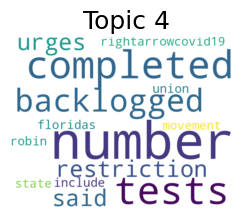

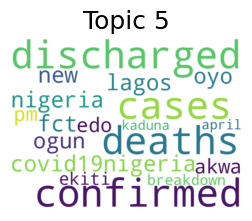

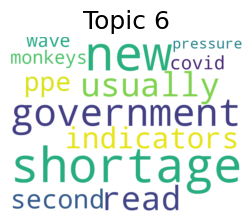

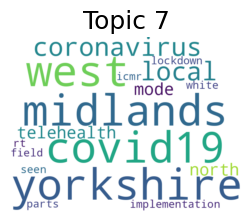

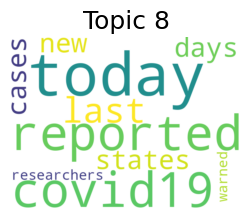

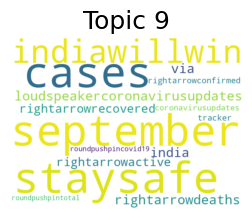

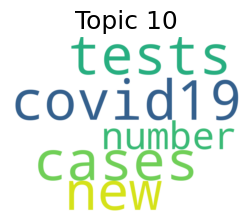

In [ ]:
# Display the word clouds for each topic
display_word_clouds(lda_fake_model, tfidf_feature_names, no_topics, num_words)
# Display the word clouds for each topic
display_word_clouds(lda_real_model, tfidf_feature_names, no_topics, num_words)

bert and biderctional LSTM

In [ ]:
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768,
                            hidden_size = 768,
                            num_layers = 2,
                            batch_first = True,
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
# Initializing model
PATH1 = "/content/drive/MyDrive/'bert_finetune.pt'"
the_best_model = torch.load(PATH1,map_location='cpu')
model4 = BertLstmClassifier(the_best_model).cuda()
# set parameters
epochs = 6
learning_rate = 5e-5
optimizer = AdamW(model4.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')
    total_train_loss = 0
    total_train_accuracy = 0
    model4.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model4.zero_grad()
        out = model4(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model4.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))



Epoch 1 / 6
Training...
  Accuracy: 0.9676358601592246
  Training loss: 0.021632952110789645

Epoch 2 / 6
Training...
  Accuracy: 0.9773277950848044
  Training loss: 0.021039563774361086

Epoch 3 / 6
Training...
  Accuracy: 0.9788854274835583
  Training loss: 0.02093789876332618

Epoch 4 / 6
Training...
  Accuracy: 0.971270335756317
  Training loss: 0.021422750548987953

Epoch 5 / 6
Training...


KeyboardInterrupt: ignored

In [ ]:
for epoch_i in range(0, epochs):
    # Validation
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print("")
    print("Validation...")
    model4.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model4(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))

In [ ]:
PATH2 = "/content/drive/MyDrive/'lstm1.pt'"
torch.save(model4, PATH2)

In [ ]:
# Prepare the model for evaluation
model4.eval()

# List to store misclassified tweets
misclassified_tweets = []

with torch.no_grad():
    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        out = model4(input_ids=input_ids, attention_mask=input_mask, token_type_ids=None)
        pred = torch.argmax(out, dim=1)

        # Compare predictions with true labels
        for input_id, prediction, true_label in zip(input_ids, pred, labels):
            if prediction != true_label:
                decoded_tweet = tokenizer.decode(input_id, skip_special_tokens=True)
                misclassified_tweets.append((decoded_tweet, true_label.item(), prediction.item()))


# Print the misclassified tweets
for tweet, true_label, pred_label in misclassified_tweets:
    print(f"Tweet: {tweet}\nTrue Label: {true_label}, Predicted Label: {pred_label}\n")

